In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9086
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  F7UPK8AX_14_07_44
NN-MODEL FILENAME:  ./models/F7UPK8AX_14_07_44_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1324.84 MiB, increment: 1104.79 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   17419
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 62
TOTAL SERIAL TIMESTEPS:   17419
TOTAL PARALLEL TIMESTEPS: 62


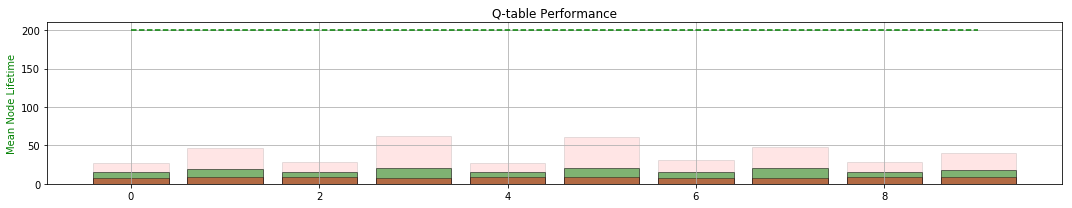

MEMORY COUNTER:  17419
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 515.080	LOSS : 477.552	LOSS : 483.459	LOSS : 483.573	LOSS : 483.032	LOSS : 457.189	LOSS : 480.903	LOSS : 456.206	LOSS : 492.882	LOSS : 467.211	LOSS : 430.347	LOSS : 450.817	LOSS : 437.742	LOSS : 438.834	LOSS : 434.270	LOSS : 433.910	LOSS : 430.778	LOSS : 417.383	LOSS : 403.236	LOSS : 420.943	
Validating... MEAN TIME:  116.195
LOSS : 421.132	LOSS : 413.041	LOSS : 414.270	LOSS : 405.677	LOSS : 415.975	LOSS : 395.771	LOSS : 397.619	LOSS : 419.162	LOSS : 419.753	LOSS : 420.148	LOSS : 426.322	LOSS : 399.904	LOSS : 408.458	LOSS : 391.304	LOSS : 401.059	LOSS : 403.411	LOSS : 396.334	LOSS : 395.979	LOSS : 400.419	LOSS : 406.268	
Validating... MEAN TIME:  127.665
LOSS : 399.254	LOSS : 389.779	LOSS : 397.829	LOSS : 385.171	LOSS : 400.739	LOSS : 396.322	LOSS : 387.937	LOSS : 385.549	LOSS : 392.709	LOSS : 399.167	LOSS : 389.393	LOSS : 407.126	LOSS : 381.437	LOSS : 408.615	LOSS : 387.364	LOSS : 404.992	LOSS : 3

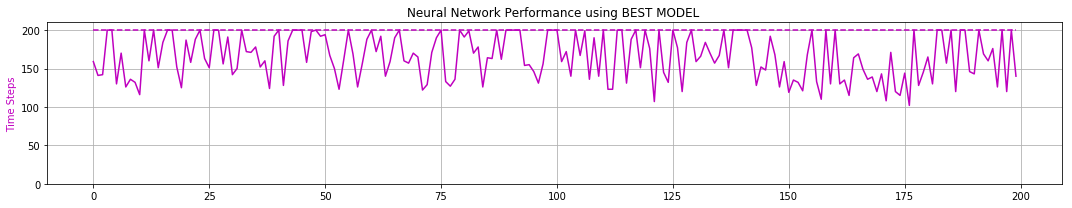

peak memory: 1314.24 MiB, increment: 1035.30 MiB
0 -max- [ 0.050  0.222  0.209  2.928]
0 -min- [-0.230 -1.990 -0.049 -0.141]

1 -max- [ 0.426  1.976  0.090  0.768]
1 -min- [-0.109 -0.975 -0.209 -2.762]

2 -max- [ 0.050  0.397  0.209  2.568]
2 -min- [-0.209 -1.735 -0.048 -0.134]

3 -max- [ 0.298  1.760  0.086  0.812]
3 -min- [-0.112 -0.994 -0.209 -2.728]

4 -max- [ 0.049  0.389  0.209  2.716]
4 -min- [-0.214 -1.791 -0.048 -0.100]

5 -max- [ 0.433  1.962  0.111  0.565]
5 -min- [-0.230 -0.915 -0.209 -2.857]

6 -max- [ 0.051  0.317  0.209  2.693]
6 -min- [-0.218 -1.727 -0.049 -0.112]

7 -max- [ 0.277  1.772  0.073  0.448]
7 -min- [-0.352 -1.335 -0.209 -2.507]

8 -max- [ 0.050  0.218  0.208  2.652]
8 -min- [-0.216 -1.791 -0.050 -0.138]

9 -max- [ 0.357  1.717  0.086  0.465]
9 -min- [-0.055 -0.422 -0.209 -2.777]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   46421
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   63840
TOTAL PARALLEL TIMES

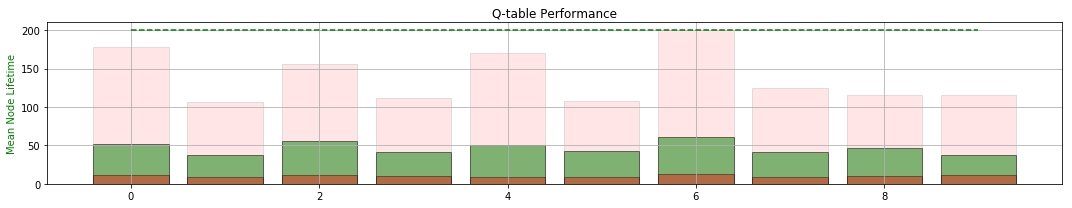

MEMORY COUNTER:  63840
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 388.681	LOSS : 394.312	LOSS : 371.638	LOSS : 384.755	LOSS : 375.878	LOSS : 369.165	LOSS : 384.907	LOSS : 390.065	LOSS : 375.393	LOSS : 362.458	LOSS : 355.345	LOSS : 340.085	LOSS : 348.844	LOSS : 354.891	LOSS : 342.997	LOSS : 341.508	LOSS : 345.280	LOSS : 344.132	LOSS : 330.058	LOSS : 330.781	
Validating... MEAN TIME:  176.845
LOSS : 345.736	LOSS : 330.893	LOSS : 321.862	LOSS : 344.844	LOSS : 326.182	LOSS : 325.214	LOSS : 338.679	LOSS : 326.125	LOSS : 343.176	LOSS : 307.540	LOSS : 305.278	LOSS : 322.652	LOSS : 324.836	LOSS : 321.998	LOSS : 330.774	LOSS : 331.979	LOSS : 319.102	LOSS : 340.123	LOSS : 336.797	LOSS : 317.178	
Validating... MEAN TIME:  180.03
LOSS : 319.824	LOSS : 327.803	LOSS : 327.363	LOSS : 310.847	LOSS : 310.843	LOSS : 322.327	LOSS : 320.619	LOSS : 323.043	LOSS : 315.449	LOSS : 308.855	LOSS : 308.792	LOSS : 316.054	LOSS : 327.954	LOSS : 314.118	LOSS : 315.791	LOSS : 311.095	LOSS : 32

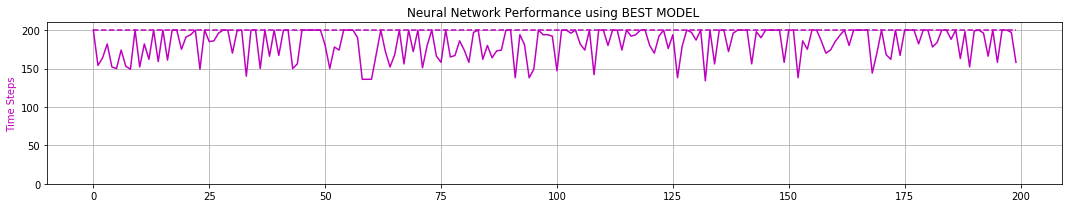

peak memory: 1405.89 MiB, increment: 1064.34 MiB
0 -max- [ 1.091  1.878  0.209  2.398]
0 -min- [-0.333 -1.583 -0.074 -1.449]

1 -max- [ 0.218  1.421  0.048  1.326]
1 -min- [-1.010 -1.697 -0.209 -2.496]

2 -max- [ 1.017  1.674  0.209  2.434]
2 -min- [-0.852 -1.572 -0.209 -1.515]

3 -max- [ 0.234  1.403  0.049  1.322]
3 -min- [-1.037 -1.853 -0.209 -2.690]

4 -max- [ 0.741  1.658  0.209  2.577]
4 -min- [-0.319 -1.551 -0.062 -1.304]

5 -max- [ 0.213  1.411  0.050  1.295]
5 -min- [-0.986 -1.674 -0.209 -2.519]

6 -max- [ 0.903  1.842  0.209  2.343]
6 -min- [-1.178 -1.909 -0.206 -1.632]

7 -max- [ 0.235  1.394  0.050  1.611]
7 -min- [-0.968 -1.720 -0.209 -2.295]

8 -max- [ 1.048  1.857  0.209  2.340]
8 -min- [-0.385 -1.572 -0.101 -1.617]

9 -max- [ 0.193  1.599  0.049  1.355]
9 -min- [-1.019 -1.665 -0.209 -2.408]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   98955
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   162795
TOTAL PARALLEL TIM

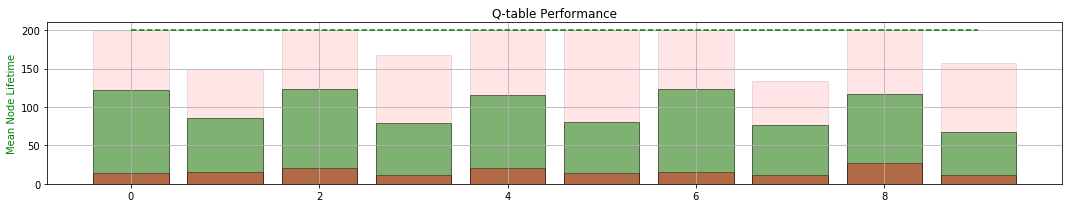

MEMORY COUNTER:  162795
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 233.648	LOSS : 219.323	LOSS : 222.990	LOSS : 214.178	LOSS : 217.540	LOSS : 220.813	LOSS : 213.618	LOSS : 192.862	LOSS : 195.493	LOSS : 185.881	LOSS : 202.446	LOSS : 196.774	LOSS : 180.302	LOSS : 212.647	LOSS : 198.893	LOSS : 205.862	LOSS : 192.178	LOSS : 193.686	LOSS : 203.810	LOSS : 205.345	
Validating... MEAN TIME:  195.56
LOSS : 193.666	LOSS : 207.078	LOSS : 195.784	LOSS : 196.846	LOSS : 214.164	LOSS : 180.711	LOSS : 187.142	LOSS : 190.711	LOSS : 198.922	LOSS : 196.411	LOSS : 184.972	LOSS : 203.079	LOSS : 186.710	LOSS : 180.828	LOSS : 197.931	LOSS : 191.159	LOSS : 185.954	LOSS : 184.701	LOSS : 185.491	LOSS : 197.097	
Validating... MEAN TIME:  196.895
LOSS : 187.240	LOSS : 196.017	LOSS : 193.127	LOSS : 184.069	LOSS : 170.172	LOSS : 181.316	LOSS : 185.823	LOSS : 207.660	LOSS : 188.094	LOSS : 195.177	LOSS : 203.320	LOSS : 188.315	LOSS : 203.793	LOSS : 207.874	LOSS : 194.811	LOSS : 186.667	LOSS : 2

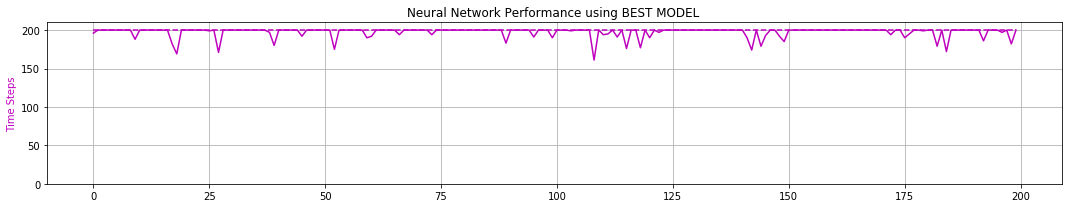

peak memory: 1404.45 MiB, increment: 977.07 MiB
0 -max- [ 1.906  2.408  0.209  3.037]
0 -min- [-1.413 -2.053 -0.208 -2.019]

1 -max- [ 0.198  1.337  0.112  1.958]
1 -min- [-1.499 -2.436 -0.209 -2.329]

2 -max- [ 1.683  2.166  0.209  2.540]
2 -min- [-1.813 -2.397 -0.209 -1.977]

3 -max- [ 0.205  1.537  0.098  1.871]
3 -min- [-1.546 -2.402 -0.209 -2.527]

4 -max- [ 1.848  2.453  0.209  2.187]
4 -min- [-1.649 -2.432 -0.209 -2.119]

5 -max- [ 0.255  1.610  0.096  1.917]
5 -min- [-1.512 -2.275 -0.209 -2.784]

6 -max- [ 1.782  2.261  0.209  2.538]
6 -min- [-1.477 -2.277 -0.209 -2.156]

7 -max- [ 0.185  1.419  0.097  1.911]
7 -min- [-1.503 -2.431 -0.209 -2.383]

8 -max- [ 1.525  2.085  0.209  2.273]
8 -min- [-1.414 -2.060 -0.208 -1.977]

9 -max- [ 0.183  1.409  0.105  1.831]
9 -min- [-1.630 -2.409 -0.209 -2.347]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   151373
SMALLEST TIMESTEP: 74
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   314168
TOTAL PARALLEL TIM

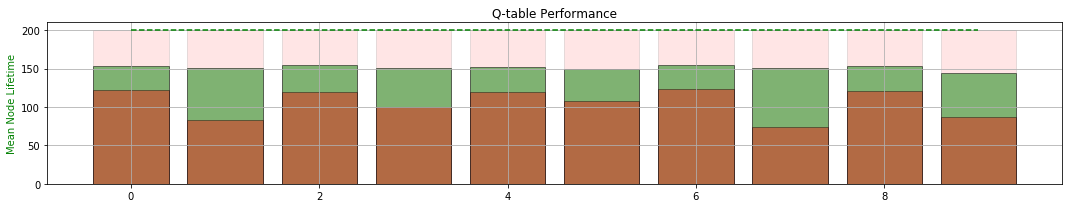

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 70.023	LOSS : 61.257	LOSS : 74.893	LOSS : 67.015	LOSS : 79.115	LOSS : 68.397	LOSS : 72.329	LOSS : 68.362	LOSS : 74.653	LOSS : 67.457	LOSS : 60.487	LOSS : 69.857	LOSS : 73.726	LOSS : 72.355	LOSS : 71.347	LOSS : 69.669	LOSS : 71.632	LOSS : 75.050	LOSS : 78.404	LOSS : 68.242	
Validating... MEAN TIME:  115.695
LOSS : 66.740	LOSS : 73.396	LOSS : 67.985	LOSS : 78.595	LOSS : 62.258	LOSS : 70.822	LOSS : 69.136	LOSS : 71.977	LOSS : 81.082	LOSS : 73.970	LOSS : 72.745	LOSS : 71.235	LOSS : 74.599	LOSS : 69.984	LOSS : 67.931	LOSS : 67.230	LOSS : 63.592	LOSS : 70.066	LOSS : 76.733	LOSS : 73.837	
Validating... MEAN TIME:  196.885
LOSS : 65.196	LOSS : 76.547	LOSS : 66.721	LOSS : 70.089	LOSS : 67.413	LOSS : 63.690	LOSS : 65.445	LOSS : 64.167	LOSS : 64.847	LOSS : 69.055	LOSS : 68.554	LOSS : 72.235	LOSS : 67.615	LOSS : 67.367	LOSS : 67.130	LOSS : 70.624	LOSS : 67.050	LOSS : 68.438	LOSS : 71.773	LOSS : 63.223	
Valida

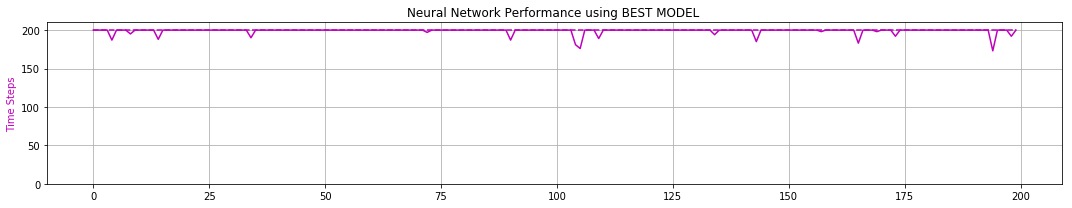

peak memory: 1448.64 MiB, increment: 1015.99 MiB
0 -max- [ 1.154  1.347  0.135  1.571]
0 -min- [-2.170 -2.835 -0.209 -1.739]

1 -max- [ 0.565  0.989  0.095  1.459]
1 -min- [-2.134 -2.420 -0.209 -1.369]

2 -max- [ 0.392  0.956  0.091  1.229]
2 -min- [-2.212 -2.610 -0.209 -1.550]

3 -max- [ 0.997  1.359  0.126  1.615]
3 -min- [-2.146 -2.975 -0.209 -2.030]

4 -max- [ 1.001  1.154  0.108  1.552]
4 -min- [-2.390 -3.353 -0.209 -1.628]

5 -max- [ 1.079  1.150  0.109  1.519]
5 -min- [-2.003 -2.759 -0.209 -1.612]

6 -max- [ 0.482  1.122  0.094  1.590]
6 -min- [-2.113 -2.406 -0.209 -1.635]

7 -max- [ 0.598  0.834  0.068  1.496]
7 -min- [-2.193 -2.777 -0.209 -1.619]

8 -max- [ 0.363  1.148  0.084  1.587]
8 -min- [-2.392 -3.147 -0.209 -1.718]

9 -max- [ 0.680  0.949  0.094  1.531]
9 -min- [-2.120 -2.846 -0.209 -1.958]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   170189
SMALLEST TIMESTEP: 136
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   484357
TOTAL PARALLEL T

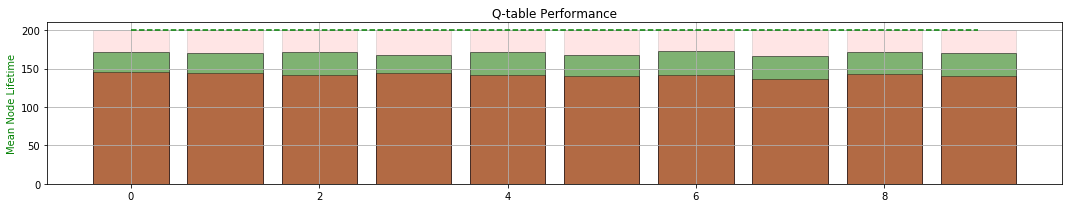

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 53.957	LOSS : 64.736	LOSS : 58.144	LOSS : 55.286	LOSS : 64.019	LOSS : 56.384	LOSS : 56.603	LOSS : 64.530	LOSS : 62.934	LOSS : 59.161	LOSS : 57.487	LOSS : 60.482	LOSS : 57.725	LOSS : 71.131	LOSS : 58.870	LOSS : 59.844	LOSS : 68.327	LOSS : 59.797	LOSS : 58.571	LOSS : 65.404	
Validating... MEAN TIME:  115.62
LOSS : 58.891	LOSS : 57.586	LOSS : 56.155	LOSS : 52.509	LOSS : 62.183	LOSS : 59.929	LOSS : 60.182	LOSS : 57.767	LOSS : 61.973	LOSS : 51.267	LOSS : 53.586	LOSS : 61.534	LOSS : 56.667	LOSS : 52.313	LOSS : 61.892	LOSS : 60.561	LOSS : 58.472	LOSS : 56.452	LOSS : 50.804	LOSS : 59.122	
Validating... MEAN TIME:  143.08
LOSS : 53.069	LOSS : 58.087	LOSS : 51.950	LOSS : 56.317	LOSS : 55.514	LOSS : 52.678	LOSS : 51.984	LOSS : 51.946	LOSS : 59.568	LOSS : 58.662	LOSS : 48.170	LOSS : 53.297	LOSS : 54.300	LOSS : 53.189	LOSS : 51.953	LOSS : 53.911	LOSS : 52.343	LOSS : 52.328	LOSS : 57.179	LOSS : 56.590	
Validati

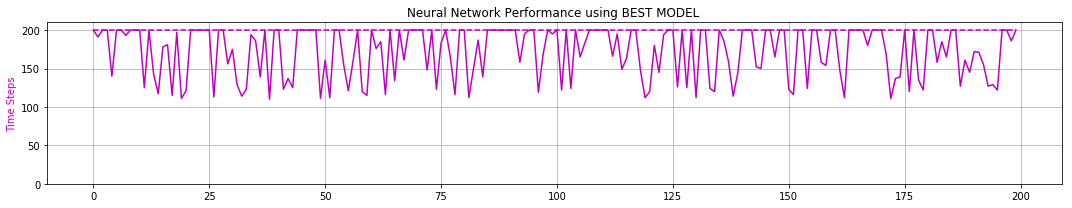

peak memory: 1481.46 MiB, increment: 1015.16 MiB
0 -max- [ 0.904  1.153  0.111  1.741]
0 -min- [-2.400 -3.197 -0.206 -1.418]

1 -max- [ 0.089  0.632  0.067  1.630]
1 -min- [-2.400 -3.306 -0.202 -1.007]

2 -max- [ 0.132  0.637  0.068  1.687]
2 -min- [-2.400 -3.200 -0.203 -1.080]

3 -max- [ 0.148  0.801  0.053  1.639]
3 -min- [-2.399 -3.200 -0.207 -1.113]

4 -max- [ 0.212  0.642  0.095  1.896]
4 -min- [-2.400 -3.347 -0.204 -1.024]

5 -max- [ 0.110  0.638  0.067  1.628]
5 -min- [-2.400 -3.206 -0.207 -1.091]

6 -max- [ 0.131  0.639  0.096  1.747]
6 -min- [-2.399 -3.196 -0.204 -1.027]

7 -max- [ 0.099  0.789  0.050  1.634]
7 -min- [-2.400 -3.299 -0.209 -1.199]

8 -max- [ 0.624  0.635  0.069  1.619]
8 -min- [-2.399 -3.177 -0.204 -1.163]

9 -max- [ 0.196  0.828  0.063  1.618]
9 -min- [-2.400 -3.195 -0.206 -1.336]

Quantization TIME:  0.01 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   61641
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 116
TOTAL SERIAL TIMESTEPS:   545998
TOTAL PARALLEL TIM

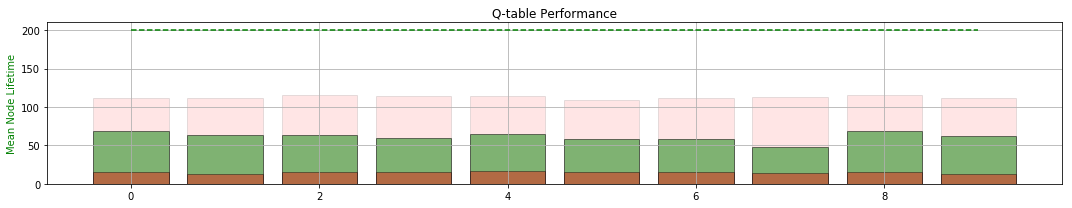

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 109.718	LOSS : 112.279	LOSS : 98.966	LOSS : 95.884	LOSS : 89.594	LOSS : 94.404	LOSS : 87.916	LOSS : 91.777	LOSS : 94.125	LOSS : 97.326	LOSS : 98.163	LOSS : 102.986	LOSS : 86.090	LOSS : 90.860	LOSS : 86.694	LOSS : 90.230	LOSS : 90.428	LOSS : 75.776	LOSS : 81.376	LOSS : 87.035	
Validating... MEAN TIME:  142.565
LOSS : 70.519	LOSS : 88.976	LOSS : 87.543	LOSS : 76.414	LOSS : 84.900	LOSS : 89.374	LOSS : 83.758	LOSS : 81.412	LOSS : 82.947	LOSS : 87.500	LOSS : 88.234	LOSS : 81.179	LOSS : 75.146	LOSS : 74.850	LOSS : 71.494	LOSS : 90.519	LOSS : 75.638	LOSS : 82.371	LOSS : 88.868	LOSS : 83.358	
Validating... MEAN TIME:  109.935
LOSS : 78.081	LOSS : 81.605	LOSS : 90.226	LOSS : 85.443	LOSS : 87.871	LOSS : 81.459	LOSS : 82.241	LOSS : 80.737	LOSS : 85.033	LOSS : 92.528	LOSS : 81.769	LOSS : 74.153	LOSS : 75.602	LOSS : 78.392	LOSS : 81.983	LOSS : 86.593	LOSS : 80.846	LOSS : 74.558	LOSS : 84.876	LOSS : 84.654	
Val

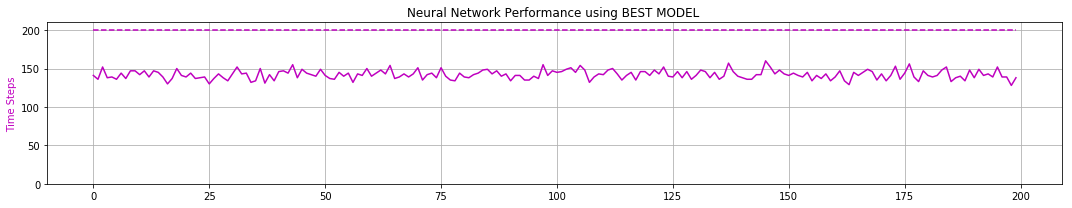

peak memory: 1488.85 MiB, increment: 992.53 MiB
0 -max- [ 0.200  0.752  0.052  0.846]
0 -min- [-2.400 -3.259 -0.209 -1.096]

1 -max- [ 0.199  0.822  0.050  0.682]
1 -min- [-2.397 -3.165 -0.209 -1.407]

2 -max- [ 0.212  0.641  0.048  0.689]
2 -min- [-2.396 -3.347 -0.209 -1.088]

3 -max- [ 0.210  0.826  0.050  0.689]
3 -min- [-2.399 -3.249 -0.209 -1.267]

4 -max- [ 0.192  0.639  0.049  0.927]
4 -min- [-2.397 -3.159 -0.209 -1.095]

5 -max- [ 0.183  0.807  0.049  0.698]
5 -min- [-2.398 -3.161 -0.209 -1.094]

6 -max- [ 0.192  0.759  0.050  0.871]
6 -min- [-2.400 -3.156 -0.209 -1.092]

7 -max- [ 0.216  0.813  0.049  0.685]
7 -min- [-2.399 -3.159 -0.209 -1.473]

8 -max- [ 0.218  0.789  0.050  0.701]
8 -min- [-2.400 -3.248 -0.209 -1.094]

9 -max- [ 0.201  0.822  0.049  0.701]
9 -min- [-2.400 -3.164 -0.209 -1.342]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   156439
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   702437
TOTAL PARALLEL TIM

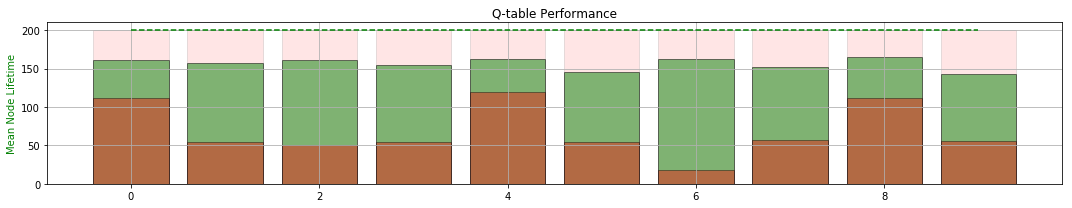

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 164.400	LOSS : 131.345	LOSS : 105.205	LOSS : 94.932	LOSS : 94.801	LOSS : 94.075	LOSS : 101.458	LOSS : 96.384	LOSS : 87.822	LOSS : 106.817	LOSS : 91.314	LOSS : 96.196	LOSS : 80.939	LOSS : 81.132	LOSS : 75.230	LOSS : 89.596	LOSS : 80.961	LOSS : 84.141	LOSS : 86.263	LOSS : 78.387	
Validating... MEAN TIME:  197.0
LOSS : 72.786	LOSS : 73.879	LOSS : 78.089	LOSS : 92.374	LOSS : 80.913	LOSS : 83.989	LOSS : 74.483	LOSS : 73.056	LOSS : 81.453	LOSS : 78.872	LOSS : 83.716	LOSS : 87.102	LOSS : 87.531	LOSS : 78.511	LOSS : 70.019	LOSS : 92.386	LOSS : 81.009	LOSS : 71.999	LOSS : 82.535	LOSS : 81.543	
Validating... MEAN TIME:  171.245
LOSS : 77.497	LOSS : 85.212	LOSS : 68.428	LOSS : 76.459	LOSS : 71.089	LOSS : 84.508	LOSS : 80.191	LOSS : 73.671	LOSS : 83.287	LOSS : 79.022	LOSS : 78.274	LOSS : 71.730	LOSS : 73.660	LOSS : 75.102	LOSS : 76.745	LOSS : 76.550	LOSS : 72.781	LOSS : 85.832	LOSS : 76.944	LOSS : 70.373	
Val

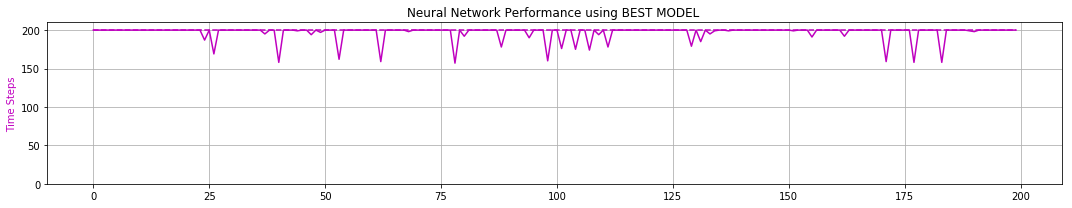

peak memory: 1473.89 MiB, increment: 1016.05 MiB
0 -max- [ 2.395  2.788  0.209  1.931]
0 -min- [-0.158 -1.548 -0.202 -2.133]

1 -max- [ 1.984  2.624  0.209  1.702]
1 -min- [-0.175 -1.482 -0.209 -2.146]

2 -max- [ 2.396  2.501  0.209  1.676]
2 -min- [-0.164 -1.478 -0.191 -1.973]

3 -max- [ 2.128  2.625  0.209  1.967]
3 -min- [-0.162 -1.769 -0.209 -2.133]

4 -max- [ 2.400  2.830  0.209  1.771]
4 -min- [-0.153 -1.508 -0.198 -1.970]

5 -max- [ 1.789  2.504  0.209  1.942]
5 -min- [-0.187 -1.735 -0.207 -2.089]

6 -max- [ 2.397  2.681  0.209  1.732]
6 -min- [-0.162 -1.401 -0.208 -2.197]

7 -max- [ 1.928  2.687  0.209  1.785]
7 -min- [-0.163 -1.530 -0.208 -2.266]

8 -max- [ 2.392  2.501  0.209  1.652]
8 -min- [-0.184 -1.371 -0.195 -1.978]

9 -max- [ 1.980  2.647  0.209  1.974]
9 -min- [-0.168 -1.676 -0.209 -2.230]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   159568
SMALLEST TIMESTEP: 93
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   862005
TOTAL PARALLEL TI

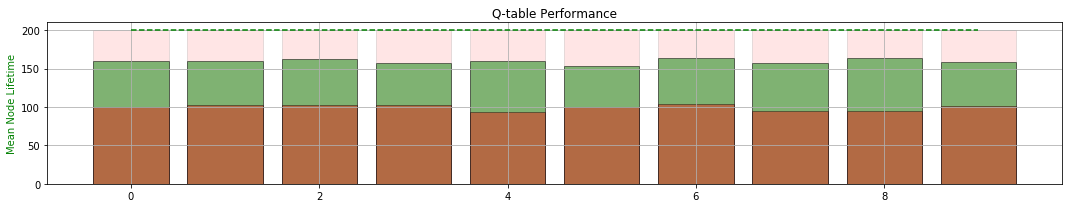

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 52.892	LOSS : 47.476	LOSS : 48.061	LOSS : 55.378	LOSS : 54.077	LOSS : 45.449	LOSS : 49.031	LOSS : 48.970	LOSS : 49.582	LOSS : 43.480	LOSS : 55.589	LOSS : 53.540	LOSS : 45.051	LOSS : 51.965	LOSS : 47.901	LOSS : 47.958	LOSS : 49.644	LOSS : 47.989	LOSS : 47.071	LOSS : 47.893	
Validating... MEAN TIME:  199.545
LOSS : 54.339	LOSS : 52.745	LOSS : 48.255	LOSS : 48.409	LOSS : 56.228	LOSS : 54.766	LOSS : 50.230	LOSS : 47.209	LOSS : 46.540	LOSS : 47.877	LOSS : 56.080	LOSS : 46.980	LOSS : 52.845	LOSS : 45.955	LOSS : 48.882	LOSS : 42.332	LOSS : 51.800	LOSS : 49.300	LOSS : 39.475	LOSS : 37.278	
Validating... MEAN TIME:  200.0
LOSS : 50.636	LOSS : 54.364	LOSS : 45.673	LOSS : 52.785	LOSS : 46.078	LOSS : 47.796	LOSS : 47.575	LOSS : 50.556	LOSS : 43.079	LOSS : 41.147	LOSS : 46.874	LOSS : 47.814	LOSS : 40.542	LOSS : 44.245	LOSS : 47.936	LOSS : 47.269	LOSS : 54.341	LOSS : 57.473	LOSS : 45.258	LOSS : 55.565	
Validati

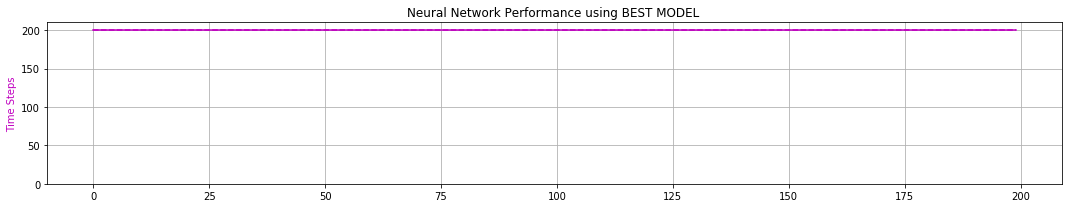

peak memory: 1491.11 MiB, increment: 1002.55 MiB
0 -max- [ 1.270  0.763  0.048  0.728]
0 -min- [-1.108 -1.641 -0.209 -0.804]

1 -max- [ 1.320  0.766  0.050  0.552]
1 -min- [-1.077 -1.658 -0.209 -1.128]

2 -max- [ 1.399  0.947  0.050  0.719]
2 -min- [-1.111 -1.659 -0.209 -0.806]

3 -max- [ 1.298  0.796  0.049  0.706]
3 -min- [-1.037 -1.628 -0.209 -1.024]

4 -max- [ 1.165  0.947  0.078  1.062]
4 -min- [-1.112 -1.819 -0.209 -1.167]

5 -max- [ 1.371  0.799  0.049  0.710]
5 -min- [-1.043 -1.659 -0.209 -1.037]

6 -max- [ 1.395  0.910  0.100  1.008]
6 -min- [-1.075 -1.666 -0.209 -0.842]

7 -max- [ 1.243  0.944  0.063  0.701]
7 -min- [-1.057 -1.646 -0.209 -1.064]

8 -max- [ 1.285  0.939  0.062  0.980]
8 -min- [-1.081 -1.666 -0.209 -0.806]

9 -max- [ 1.310  0.931  0.049  0.713]
9 -min- [-1.048 -1.638 -0.209 -1.316]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   200000
SMALLEST TIMESTEP: 200
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1062005
TOTAL PARALLEL 

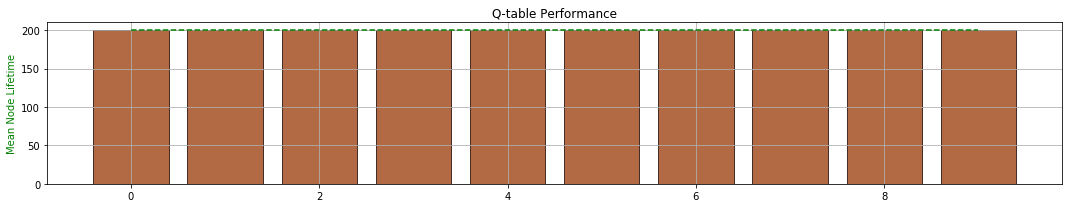

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1578.0
Total Serial Timesteps   :  1062005.0
Speed-up                 :  673.01


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9086 SUCCESS 200   8    1578    1062005     673.01


In [24]:
node_boundaries

array([[ 1.225,  1.120,  0.083,  0.912, -0.117, -0.910, -0.085, -0.748],
       [ 1.216,  1.165,  0.060,  0.884, -0.123, -0.794, -0.100, -1.009],
       [ 1.238,  1.103,  0.092,  0.886, -0.141, -0.765, -0.086, -0.758],
       [ 1.189,  1.103,  0.060,  1.180, -0.152, -0.771, -0.102, -1.198],
       [ 1.254,  1.103,  0.102,  0.890, -0.130, -0.807, -0.086, -0.841],
       [ 1.202,  1.077,  0.061,  1.139, -0.127, -0.757, -0.160, -1.063],
       [ 1.224,  1.125,  0.079,  1.144, -0.176, -0.797, -0.085, -0.908],
       [ 1.195,  1.160,  0.060,  0.871, -0.119, -0.761, -0.128, -0.994],
       [ 1.254,  1.136,  0.085,  0.890, -0.118, -0.791, -0.087, -0.964],
       [ 1.210,  1.094,  0.060,  0.872, -0.140, -0.760, -0.100, -0.885]])